In [2]:
import requests
from bs4 import BeautifulSoup
from itertools import cycle
import argparse
import io
import math

import pandas as pd
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

In [3]:
def cleanString(stng):

    output = ''

    for letter in stng:
        if letter.isdigit() or letter == '.' or letter == '%' or letter == '-':
            output += letter
        
    if '%' not in output and len(output) > 0:
        return float(output)
    else:
        if '%' in output:
            return output
        else:
            return 0
        
def getProxies(inURL):
    
    page = requests.get(inURL)
    soup = BeautifulSoup(page.text, 'html.parser')
    terms = soup.find_all('tr')
    IPs = []

    for x in range(len(terms)):  
        
        term = str(terms[x])        
        
        if '<tr><td>' in str(terms[x]):
            pos1 = term.find('d>') + 2
            pos2 = term.find('</td>')

            pos3 = term.find('</td><td>') + 9
            pos4 = term.find('</td><td>US<')
            
            IP = term[pos1:pos2]
            port = term[pos3:pos4]
            
            if '.' in IP and len(port) < 6:
                IPs.append(IP + ":" + port)
                #print(IP + ":" + port)

    return IPs 


proxyURL = "https://www.us-proxy.org/"
pxs = getProxies(proxyURL)
proxyPool = cycle(pxs)

In [108]:
def extractNums(stng):

    output = []

    while '>' in stng:
        
        stng = stng[stng.find('>') + 1 : ]

        num = stng[0 : stng.find('</')]

        if len(num) < 10:
            try:
                output.append(float(num))
            except:
                if num.isdigit():
                    output.append(float(num))
                elif ('%' in num):
                    output.append(cleanString(num))
                #elif ',' in num:
                    #print('&&&&&&&&&&&&&&', num)
            
    return output

In [180]:
def getPlayerRating(per100PossStats, advancedStats, playByPlayStats):
    
    minutesPlayed = per100PossStats[-1][1][3]
    gamesPlayed = per100PossStats[-1][1][1]
    offRating = per100PossStats[-1][1][-2]
    defRating = per100PossStats[-1][1][-1]
    ptsPer100 = per100PossStats[-1][1][-3]
    astPer100 = per100PossStats[-1][1][-8]
    trbPer100 = per100PossStats[-1][1][-9]
    stlPer100 = per100PossStats[-1][1][-7]
    blkPer100 = per100PossStats[-1][1][-6]
    tovPer100 = per100PossStats[-1][1][-5]

    tsPercentage = advancedStats[-1][1][4]
    wsPer48 = advancedStats[-1][1][-5]
    boxPlusMinus = advancedStats[-1][1][-2]
    vorp = advancedStats[-1][1][-1]

    plusMinusOnCourt = playByPlayStats[-1][1][-11]
    plusMinusNet = playByPlayStats[-1][1][-10]

    if '%' in str(plusMinusOnCourt) or '%' in str(plusMinusNet) or plusMinusOnCourt > 20 or plusMinusNet > 20 or minutesPlayed < 100:
        
        plusMinusOnCourt = 0
        plusMinusNet = 0
        boxPlusMinus = 0
        wsPer48 = 0
        vorp = 0

    playerRating = (((ptsPer100 + astPer100 + trbPer100 + stlPer100 + blkPer100 + (tsPercentage * 10) - tovPer100 + (((wsPer48 + boxPlusMinus + vorp) * 5 + (plusMinusOnCourt + plusMinusNet) / 2) * 2) * 3) + ((minutesPlayed / gamesPlayed) * 2))) / 7.5

    if playerRating < 0:
        playerRating = 0
        
    return playerRating 


def getPlayerRatingGrowth(age, per100PossStats, advancedStats, playByPlayStats):
    
    seasonRatings = []
    seasonRatingsGrowth = []
    x = 1
    
    if len(per100PossStats) >= 2:
        
        while x <= len(per100PossStats):
        
            minutesPlayed = per100PossStats[0 - x][1][3]
            gamesPlayed = per100PossStats[0 - x][1][1]
            offRating = per100PossStats[0 - x][1][-2]
            defRating = per100PossStats[0 - x][1][-1]
            ptsPer100 = per100PossStats[0 - x][1][-3]
            astPer100 = per100PossStats[0 - x][1][-8]
            trbPer100 = per100PossStats[0 - x][1][-9]
            stlPer100 = per100PossStats[0 - x][1][-7]
            blkPer100 = per100PossStats[0 - x][1][-6]
            tovPer100 = per100PossStats[0 - x][1][-5]

            tsPercentage = advancedStats[0 - x][1][4]
            wsPer48 = advancedStats[0 - x][1][-5]
            boxPlusMinus = advancedStats[0 - x][1][-2]
            vorp = advancedStats[0 - x][1][-1]

            plusMinusOnCourt = playByPlayStats[0 - x][1][-11]
            plusMinusNet = playByPlayStats[0 - x][1][-10]
                                
            
            if '%' in str(plusMinusOnCourt) or '%' in str(plusMinusNet) or plusMinusOnCourt > 20 or plusMinusNet > 20 or minutesPlayed < 100:
                
                ptsPer100 = 0
                astPer100 = 0
                trbPer100 = 0
                plusMinusOnCourt = 0
                plusMinusNet = 0
                boxPlusMinus = 0
                wsPer48 = 0
                vorp = 0
            
                
            playerRating = (((((ptsPer100 + astPer100 + trbPer100 + stlPer100 + blkPer100) * 2) + (tsPercentage * 20) - tovPer100 + (((wsPer48 + boxPlusMinus + vorp) * 5 + (plusMinusOnCourt + plusMinusNet) / 2) * 2) * 3) + (((minutesPlayed * 2) / gamesPlayed) * 5))) / 10
                
                
            if playerRating < 0:
                playerRating = 0

            seasonRatings.append(playerRating)
            
            x += 1
    
        print('Season Ratings:', seasonRatings)
        
    
        for x in range(len(seasonRatings) - 1):
            
            if seasonRatings[x + 1] == 0:
                seasonRatingsGrowth.append(0)
            else:
                growth = (((seasonRatings[x] - seasonRatings[x + 1]) / seasonRatings[x + 1])) * 100.0
                
                if growth >= 200:
                    growth = 200
                
                seasonRatingsGrowth.append(growth)
                
        avgRating = 0
        avgGrowth = 0

        if len(seasonRatings) != 0: avgRating = sum(seasonRatings) / len(seasonRatings) 
        if len(seasonRatingsGrowth) != 0: avgGrowth = sum(seasonRatingsGrowth) / len(seasonRatingsGrowth) 

        print('Growth', seasonRatingsGrowth)

        #print('Avg Rating', avgRating)
        #print('Avg Growth', avgGrowth)

        return ((100 - (age) * 2) + avgRating + ((avgGrowth) * 2)) / 2

    else:
        
        return 20


In [181]:
allPlayerRatings = []
teamRatings = []
allPlayerGrowth = []

for x in range(1, 31):
     
    page = requests.get('https://www.basketball-reference.com/leagues/NBA_2020_standings.html', proxies = {"http": next(proxyPool)})
    soup = str(BeautifulSoup(page.text, 'html.parser'))

    indexTo = soup.find('data-stat="ranker" csk="' + str(x) + '"')
    rawTeamStats = soup[indexTo + 80 : indexTo + 1200]

    rawTeamSymbol = rawTeamStats[rawTeamStats.find('/teams') + 7 : rawTeamStats.find('/teams') + 15]
    teamSymbol = rawTeamSymbol[0 : rawTeamSymbol.find('/')]
        
    page = requests.get('https://www.basketball-reference.com/teams/' + teamSymbol + '/2020.html', proxies = {"http": next(proxyPool)})
    soup = str(BeautifulSoup(page.text, 'html.parser'))

    start = 1
    
    print('\n' + teamSymbol)
    
    avgTeamRating = []
        
    #Getting all players from the team
    
    for y in range(20):
                    
        player = soup[soup.find('data-stat="ranker" csk="' + str(start) + '"') : soup.find('data-stat="ranker" csk="' + str(start + 1) + '"')]
        name = player[player.find('data-stat="player" csk="') + 24 : player.find('" ><a href="/players')]
        
        if len(name) < 30 and len(name) > 0:
            
            try:
                name = name.split(',')[1] + ' ' + name.split(',')[0]
            except:
                print('Err', player, name)

            playerPageLink = 'https://www.basketball-reference.com/' + player[player.find('<a href="') + 10 : player.find('html">') + 4]
            start += 1

            page = requests.get(playerPageLink, proxies = {"http": next(proxyPool)})
            playerPage = str(BeautifulSoup(page.text, 'html.parser'))

            
            #Getting individual player stats 

            #if y == 0:

            #print(playerPage)

            per100PossStats = []
            per100PossText = playerPage[playerPage.find('<span class="section_anchor" data-label="Per 100 Poss"') + 20 : playerPage.find('<span class="section_anchor" data-label="Advanced"') - 180]

            advancedStats = []
            advancedStatsText = playerPage[playerPage.find('<span class="section_anchor" data-label="Advanced"') + 20 : playerPage.find('<span class="section_anchor" data-label="Adjusted Shooting"')]

            playByPlayStats = []
            playByPlayText = playerPage[playerPage.find('<span class="section_anchor" data-label="Play-by-Play"') : playerPage.find('<div class="table_wrapper setup_commented commented" id="all_year-and-career-highs">')]
            
            while 'per_poss.' in per100PossText:

                year = per100PossText[per100PossText.find('per_poss.') + 9 : per100PossText.find('per_poss.') + 13]

                per100PossText = per100PossText[per100PossText.find('per_poss.') + 15 : ]
                season100PossText = per100PossText[0 : per100PossText.find('data-stat="def_rtg" >') + 50]

                season100PossStats = extractNums(season100PossText)
                per100PossStats.append([year, season100PossStats])

                #print(year, season100PossStats)
                #print()


            while 'id="advanced.' in advancedStatsText:

                year = advancedStatsText[advancedStatsText.find('id="advanced.') + 13 : advancedStatsText.find('id="advanced.') + 17]

                advancedStatsText = advancedStatsText[advancedStatsText.find('id="advanced.') + 15 : ]
                seasonAdvStatsText = advancedStatsText[0 : advancedStatsText.find('data-stat="vorp" >') + 35]

                seasonAdvStats = extractNums(seasonAdvStatsText)
                advancedStats.append([year, seasonAdvStats])

                #print(year, seasonAdvStats)
            
            
            while '<tr id="pbp.' in playByPlayText:
                
                year = playByPlayText[playByPlayText.find('id="pbp.') + 8 : playByPlayText.find('id="pbp.') + 12]
                
                playByPlayText = playByPlayText[playByPlayText.find('id="pbp.') + 10 : ]
                seasonPlayByPlayText = playByPlayText[0 : playByPlayText.find('data-stat="own_shots_blk" >') + 30]
            
                seasonPlayByPlayStats = extractNums(seasonPlayByPlayText)
                playByPlayStats.append([year, seasonPlayByPlayStats])
                
                #print(year, seasonPlayByPlayStats[-10])
            

            ##Player Grading Based on Current Stats (2020)
            #Rating = ((Pts + Ast + Trb + Stl + Blk + (TS% * 10) + (WS/48 + Box+/- + VORP * 3) * 3) + ((MP / GP) * 2)) / 2
            
            
            playerRating = getPlayerRating(per100PossStats, advancedStats, playByPlayStats)
            
            allPlayerRatings.append([name, playerRating])
            avgTeamRating.append(playerRating)
            
            
            ##Player Potential 
            
            age = per100PossStats[-1][1][0]
            
            playerRatingGrowth = getPlayerRatingGrowth(age, per100PossStats, advancedStats, playByPlayStats)
            allPlayerGrowth.append([name, age, playerRating, playerRatingGrowth])
            
            
            print(name, age)
            print(str(playerRating)[0:6], str(playerRatingGrowth)[0:6])
            print(playerPageLink)
            print()
            
            
            
            '''
            years = [x[0] for x in per36MinsStats]
            ppg = [x[1][-1] for x in per36MinsStats]
            plt.plot(years, ppg, 'ro')
            plt.title(name + ' Per 36 Mins PPG')
            plt.show()
            '''
            
            
            
    teamRatings.append([teamSymbol, (sum(avgTeamRating) / len(avgTeamRating))])
    print(teamSymbol, (sum(avgTeamRating) / len(avgTeamRating)))


MIL
Season Ratings: [108.53182456140351, 108.32399999999998, 89.60366666666667, 91.8105, 60.6725, 43.69537037037037, 24.18536363636364]
Growth [0.1918545856906381, 20.89237419599642, -2.4036829483918893, 51.32143887263588, 38.8533830603293, 80.66865161652014]
Giannis Antetokounmpo 25.0
100.82 94.217
https://www.basketball-reference.com/players/a/antetgi01.html

Season Ratings: [67.59454545454545, 52.47292207792208, 52.52285365853659, 43.520172413793105, 56.15026582278481, 56.8822658227848, 28.181, 22.723592592592592]
Growth [28.817955581295486, -0.09506638945996519, 20.6862260543118, -22.493381329401704, -1.2868685686335333, 101.84615813060147, 24.016481483594315]
Khris Middleton 28.0
50.682 67.394
https://www.basketball-reference.com/players/m/middlkh01.html

Season Ratings: [54.00628571428572, 62.301205128205126, 62.518211267605636, 28.80466666666667, 60.800378378378376, 63.629696969696965, 59.59329032258065, 61.184901234567896, 59.906232558139536, 47.2352105263158, 16.014, 19.41039

In [182]:
allPlayerRatings = sorted(allPlayerRatings, key=lambda l:l[1], reverse=True)

In [183]:
sortedRankings = set(tuple(element) for element in allPlayerRatings)
sortedRankings = sorted(sortedRankings, key=lambda l:l[1], reverse=True)
sortedRankings

[('Giannis Antetokounmpo', 100.82661988304092),
 ('James Harden', 85.3847213114754),
 ('LeBron James', 84.87466666666666),
 ('Kawhi Leonard', 80.75218300653596),
 ('Luka Dončić', 74.49595061728395),
 ('Anthony Davis', 74.06545454545454),
 ('Nikola Jokić', 72.64748717948717),
 ('Damian Lillard', 71.25774712643677),
 ('Karl-Anthony Towns', 61.653142857142846),
 ('Jimmy Butler', 55.6474074074074),
 ('Kyrie Irving', 54.684),
 ('Jayson Tatum', 53.21123163841808),
 ('Chris Paul', 52.25297354497354),
 ('Joel Embiid', 51.65721212121211),
 ('Khris Middleton', 50.68254545454546),
 ('Rudy Gobert', 50.019569892473115),
 ('Kemba Walker', 48.15466666666667),
 ('Trae Young', 47.271555555555565),
 ('Bam Adebayo', 47.197230769230764),
 ('Paul George', 45.53339682539683),
 ('Domantas Sabonis', 44.37935483870968),
 ('Ben Simmons', 44.21086419753087),
 ('Nikola Vučević', 44.11950617283951),
 ('Hassan Whiteside', 43.944765027322404),
 ('Kyle Lowry', 41.67938461538462),
 ('Danilo Gallinari', 40.500606060606

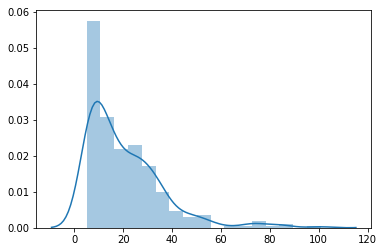

In [184]:
ratings = [x[1] for x in sortedRankings if x[1] > 5]
sns.distplot(ratings);

In [185]:
teamRatings = sorted(teamRatings, key=lambda l:l[1], reverse=True)
teamRatings

[['MIL', 22.20000192307514],
 ['DAL', 18.946276892375632],
 ['TOR', 18.491643035879406],
 ['LAC', 18.39895548292571],
 ['BOS', 18.024721435310102],
 ['LAL', 17.121596106590363],
 ['HOU', 14.921208883512975],
 ['DEN', 14.649812568001726],
 ['MEM', 14.589981340043835],
 ['UTA', 14.296630196315453],
 ['OKC', 14.28244299461338],
 ['MIA', 13.955674210520153],
 ['NOP', 13.406683517749306],
 ['PHI', 12.707129872233422],
 ['BRK', 12.368302284752284],
 ['IND', 12.285893150216518],
 ['POR', 12.001205131473705],
 ['SAS', 10.943569363286484],
 ['SAC', 10.560900255404702],
 ['PHO', 10.35573647534298],
 ['ORL', 10.233276143889952],
 ['MIN', 9.918984126984128],
 ['CHI', 9.098195314011562],
 ['DET', 9.035270033938463],
 ['WAS', 8.062364926240672],
 ['CLE', 6.791634336652912],
 ['GSW', 6.606880204583723],
 ['ATL', 6.316988540456833],
 ['CHO', 6.035268090152545],
 ['NYK', 5.306688303803059]]

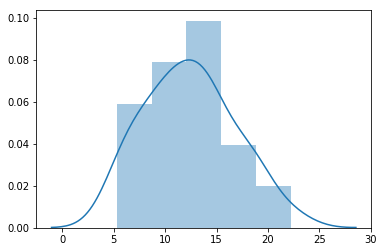

In [186]:
teamRatings = [x[1] for x in teamRatings]
sns.distplot(teamRatings);

In [187]:
sortedGrowthRankings = set(tuple(element) for element in allPlayerGrowth)
sortedGrowthRankings = sorted(sortedGrowthRankings, key=lambda l:l[3], reverse=True)
sortedGrowthRankings

[("Devonte' Graham", 24.0, 24.446730158730155, 239.97422256728777),
 ('Isaiah Hartenstein', 21.0, 16.826724637681156, 237.37401863354037),
 ('Shake Milton', 23.0, 11.018333333333334, 236.1336875),
 ('Isaac Bonga', 20.0, 3.9926436781609187, 235.10173981191224),
 ('Jevon Carter', 24.0, 5.006666666666667, 231.82346794871796),
 ('Elie Okobo', 22.0, 0, 230.91351607267646),
 ('Donte DiVincenzo', 23.0, 34.4545988700565, 203.5164890207349),
 ('Mohamed Bamba', 21.0, 18.48311111111111, 195.79970084622343),
 ('Tony Bradley', 22.0, 17.588, 184.08015490183345),
 ('Collin Sexton', 21.0, 3.0331282051282065, 180.06918961384432),
 ("De'Anthony Melton", 21.0, 21.401948717948716, 174.92950935819576),
 ('Sviatoslav Mykhailiuk', 22.0, 5.047809523809525, 165.53010622710624),
 ('Chris Boucher', 27.0, 22.17963636363636, 150.09171166118932),
 ('Bruce Brown', 23.0, 7.637977011494254, 148.44258536565212),
 ('Malik Monk', 21.0, 0, 148.30039743502104),
 ('Domantas Sabonis', 23.0, 44.37935483870968, 144.58367650427